In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['marketdata_sample.csv', 'news_sample.csv']


In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

In [4]:
# inspired by
# https://www.kaggle.com/artgor/eda-feature-engineering-and-everything

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [5]:
market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [6]:
market_train_df.isna().sum()

time                            0
assetCode                       0
assetName                       0
volume                          0
close                           0
open                            0
returnsClosePrevRaw1            0
returnsOpenPrevRaw1             0
returnsClosePrevMktres1     15980
returnsOpenPrevMktres1      15988
returnsClosePrevRaw10           0
returnsOpenPrevRaw10            0
returnsClosePrevMktres10    93010
returnsOpenPrevMktres10     93054
returnsOpenNextMktres10         0
universe                        0
dtype: int64

# Preprocessing

In [7]:
market_train_df = market_train_df.drop(columns="universe")

In [8]:
# zaviesť istú metriku, pre detekovanie
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']

grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()

print(f"Average standard deviation of price change within a day in {grouped['price_diff']['std'].mean():.4f}.")

Average standard deviation of price change within a day in 1.0335.


In [9]:
market_train_df.sort_values('price_diff')[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,price_diff
1127598,2010-01-04 22:00:00+00:00,TW.N,Towers Watson & Co,223136.0,50.00,9998.9900,-0.058470,185.988360,-0.056911,163.671298,-0.024316,189.918708,0.034162,188.184866,13.167586,-9948.9900
627547,2008-09-29 22:00:00+00:00,BK.N,Bank of New York Mellon Corp,18718479.0,26.50,3288.1136,-0.271578,99.125262,-0.064067,98.933405,-0.275164,84.405548,-0.189620,83.371024,4.061628,-3261.6136
502997,2008-06-05 22:00:00+00:00,AHG.N,Apria Healthcare Group Inc,801892.0,17.29,999.9900,0.009930,58.523214,-0.001831,58.449248,0.104792,62.410907,0.140881,54.556118,-4.176442,-982.7000
471381,2008-05-06 22:00:00+00:00,CEPH.O,Cephalon Inc,4846.0,61.04,999.9900,0.014628,15.547907,0.009554,14.982480,-0.039950,14.742916,-0.053743,14.824286,0.087719,-938.9500
242847,2007-09-27 22:00:00+00:00,EXH.N,Archrock Inc,490100.0,79.99,999.9900,0.022236,11.658101,0.018789,11.570153,0.007304,11.618170,0.012866,552.522473,-0.550395,-920.0000
3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.59,263.8000,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,-207.2100
7273,2007-02-08 22:00:00+00:00,BA.N,Boeing Co,5155700.0,89.52,200.0000,-0.009186,1.207749,-0.006835,1.202170,0.043010,1.299798,NaN,NaN,0.004434,-110.4800
375899,2008-02-06 22:00:00+00:00,CME.N,CME Group Inc,8676040.0,485.25,583.4900,-0.175866,-0.061536,-0.165490,-0.023137,-0.204495,0.025448,-0.188712,-0.021896,-0.006932,-98.2400
628075,2008-09-29 22:00:00+00:00,IBM.N,International Business Machines Corp,9586679.0,114.46,191.9800,-0.041534,0.637915,0.018300,0.634691,-0.006337,0.664182,0.010630,0.666148,0.013094,-77.5200
3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.19,612.0000,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,-75.8100


In [10]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [11]:
market_train_df['assetName_mean_open'] = market_train_df.groupby('assetName')['open'].transform('mean')
market_train_df['assetName_mean_close'] = market_train_df.groupby('assetName')['close'].transform('mean')

# if open price is too far from mean open price for this company, replace it. Otherwise replace close price.
for i, row in market_train_df.loc[market_train_df['close_to_open'] >= 2].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']
        
for i, row in market_train_df.loc[market_train_df['close_to_open'] <= 0.5].iterrows():
    if np.abs(row['assetName_mean_open'] - row['open']) > np.abs(row['assetName_mean_close'] - row['close']):
        market_train_df.iloc[i,5] = row['assetName_mean_open']
    else:
        market_train_df.iloc[i,4] = row['assetName_mean_close']

In [12]:
market_train_df.sort_values('price_diff')[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
1127598,2010-01-04 22:00:00+00:00,TW.N,Towers Watson & Co,223136.0,50.00,78.538297,-0.058470,185.988360,-0.056911,163.671298,-0.024316,189.918708,0.034162,188.184866,13.167586,-9948.9900,0.005001,78.538297,73.130319
627547,2008-09-29 22:00:00+00:00,BK.N,Bank of New York Mellon Corp,18718479.0,26.50,34.401717,-0.271578,99.125262,-0.064067,98.933405,-0.275164,84.405548,-0.189620,83.371024,4.061628,-3261.6136,0.008059,34.401717,33.105261
502997,2008-06-05 22:00:00+00:00,AHG.N,Apria Healthcare Group Inc,801892.0,17.29,26.098287,0.009930,58.523214,-0.001831,58.449248,0.104792,62.410907,0.140881,54.556118,-4.176442,-982.7000,0.017290,26.098287,23.761632
471381,2008-05-06 22:00:00+00:00,CEPH.O,Cephalon Inc,4846.0,61.04,68.956367,0.014628,15.547907,0.009554,14.982480,-0.039950,14.742916,-0.053743,14.824286,0.087719,-938.9500,0.061041,68.956367,68.147855
242847,2007-09-27 22:00:00+00:00,EXH.N,Archrock Inc,490100.0,79.99,29.846959,0.022236,11.658101,0.018789,11.570153,0.007304,11.618170,0.012866,552.522473,-0.550395,-920.0000,0.079991,29.846959,29.430992
3264631,2015-03-16 22:00:00+00:00,TECD.O,Tech Data Corp,674385.0,56.59,48.685718,0.036447,3.868057,0.020318,3.781770,-0.066172,3.442573,-0.021922,3.284477,0.072616,-207.2100,0.214519,48.685718,48.613853
7273,2007-02-08 22:00:00+00:00,BA.N,Boeing Co,5155700.0,89.52,92.403041,-0.009186,1.207749,-0.006835,1.202170,0.043010,1.299798,NaN,NaN,0.004434,-110.4800,0.447600,92.403041,92.364056
375899,2008-02-06 22:00:00+00:00,CME.N,CME Group Inc,8676040.0,485.25,583.490000,-0.175866,-0.061536,-0.165490,-0.023137,-0.204495,0.025448,-0.188712,-0.021896,-0.006932,-98.2400,0.831634,213.271243,213.112881
628075,2008-09-29 22:00:00+00:00,IBM.N,International Business Machines Corp,9586679.0,114.46,191.980000,-0.041534,0.637915,0.018300,0.634691,-0.006337,0.664182,0.010630,0.666148,0.013094,-77.5200,0.596208,150.979743,151.067168
3565205,2015-11-20 22:00:00+00:00,CMG.N,Chipotle Mexican Grill Inc,5023617.0,536.19,612.000000,-0.123171,0.027863,-0.123970,0.028139,-0.124445,0.004926,NaN,NaN,-0.001849,-75.8100,0.876127,248.401512,248.531386


In [13]:
# fill with 0s, but knowing it won't be good
# and still having outliers
market_train_df['returnsClosePrevMktres1'].fillna(0, inplace=True)

market_train_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,0.0,NaN,-0.001860,0.000622,NaN,NaN,0.034672,0.02,1.000622,38.588223,38.607230
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,0.0,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.04,1.003610,7.031961,7.021656
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,0.0,NaN,0.014332,0.045405,NaN,NaN,0.024433,-0.48,0.987365,84.275408,84.301749
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,0.0,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,-1.49,0.982721,262.223310,262.096429
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,0.0,NaN,0.012929,0.020397,NaN,NaN,-0.017994,0.01,1.000555,21.033257,21.038988


# TO DO


Check outliers within returns

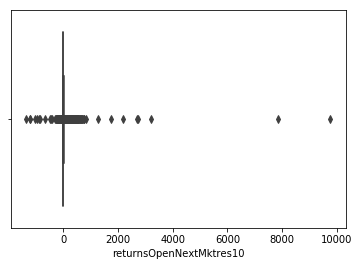

In [14]:
sns.boxplot(x=market_train_df['returnsOpenNextMktres10'])

Prediction of market residuals? Elab more

In [15]:
max(market_train_df['returnsOpenNextMktres10'])

9761.338266772531

In [16]:
market_train_df.sort_values('returnsOpenNextMktres10')[:10]

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
277852,2007-10-31 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,431705.0,57.350000,54.35,0.051136,5434.000000,0.033208,5347.353811,0.049789,-0.020721,0.044722,-0.008626,-1375.045075,3.00,1.055198,24.674957,24.674355
283697,2007-11-06 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,817261.0,56.140000,55.89,0.016661,0.023814,-0.000148,-1.826470,0.039437,0.037113,0.038767,0.041530,-1226.144264,0.25,1.004473,24.674957,24.674355
282237,2007-11-05 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,444899.0,55.220000,54.59,-0.018311,-0.036534,-0.011079,-38.512144,0.024870,0.044785,0.028541,0.036277,-1225.593265,0.63,1.011541,24.674957,24.674355
279315,2007-11-01 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,480803.0,56.420000,57.00,-0.016216,0.048758,0.018749,169.846086,0.034660,0.054579,0.056293,0.047723,-1036.400807,-0.58,0.989825,24.674957,24.674355
276388,2007-10-30 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,651547.0,24.674355,0.01,-0.036042,-0.999821,-0.027901,-1.000330,-0.008361,-0.999819,-0.004381,-0.993821,-979.306501,54.55,5456.000000,24.674957,24.674355
280778,2007-11-02 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,336500.0,56.250000,56.66,-0.003013,-0.005965,-0.004097,-258.003324,0.069595,0.044424,0.062496,0.074007,-893.641268,-0.41,0.992764,24.674957,24.674355
285159,2007-11-07 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,1348390.0,53.480000,52.40,-0.047382,-0.062444,-0.006086,73.074271,-0.015101,-0.031423,0.031031,-0.030220,-875.885316,1.08,1.020611,24.674957,24.674355
288088,2007-11-09 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,533622.0,53.030000,53.17,-0.010634,-0.010975,0.009500,-21.224913,-0.041569,-0.037299,0.052355,-0.002265,-679.811303,-0.14,0.997367,24.674957,24.674355
165718,2007-07-16 22:00:00+00:00,RRR.N,RSC Holdings Inc,335700.0,10.079162,0.01,0.009128,-0.999535,0.011301,-0.993804,0.105500,-0.999503,NaN,NaN,-482.822137,22.10,2211.000000,10.063702,10.079162
167193,2007-07-17 22:00:00+00:00,RRR.N,RSC Holdings Inc,287100.0,22.230000,22.07,0.005427,2206.000000,0.005531,2196.766806,0.104871,0.087192,NaN,NaN,-458.711208,0.16,1.007250,10.063702,10.079162


In [17]:
market_train_df.sort_values('returnsOpenNextMktres10')           

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
277852,2007-10-31 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,431705.0,57.350000,54.350000,0.051136,5434.000000,0.033208,5347.353811,0.049789,-0.020721,0.044722,-0.008626,-1375.045075,3.00,1.055198,24.674957,24.674355
283697,2007-11-06 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,817261.0,56.140000,55.890000,0.016661,0.023814,-0.000148,-1.826470,0.039437,0.037113,0.038767,0.041530,-1226.144264,0.25,1.004473,24.674957,24.674355
282237,2007-11-05 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,444899.0,55.220000,54.590000,-0.018311,-0.036534,-0.011079,-38.512144,0.024870,0.044785,0.028541,0.036277,-1225.593265,0.63,1.011541,24.674957,24.674355
279315,2007-11-01 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,480803.0,56.420000,57.000000,-0.016216,0.048758,0.018749,169.846086,0.034660,0.054579,0.056293,0.047723,-1036.400807,-0.58,0.989825,24.674957,24.674355
276388,2007-10-30 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,651547.0,24.674355,0.010000,-0.036042,-0.999821,-0.027901,-1.000330,-0.008361,-0.999819,-0.004381,-0.993821,-979.306501,54.55,5456.000000,24.674957,24.674355
280778,2007-11-02 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,336500.0,56.250000,56.660000,-0.003013,-0.005965,-0.004097,-258.003324,0.069595,0.044424,0.062496,0.074007,-893.641268,-0.41,0.992764,24.674957,24.674355
285159,2007-11-07 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,1348390.0,53.480000,52.400000,-0.047382,-0.062444,-0.006086,73.074271,-0.015101,-0.031423,0.031031,-0.030220,-875.885316,1.08,1.020611,24.674957,24.674355
288088,2007-11-09 22:00:00+00:00,ATPG.O,ATP Oil & Gas Corp,533622.0,53.030000,53.170000,-0.010634,-0.010975,0.009500,-21.224913,-0.041569,-0.037299,0.052355,-0.002265,-679.811303,-0.14,0.997367,24.674957,24.674355
165718,2007-07-16 22:00:00+00:00,RRR.N,RSC Holdings Inc,335700.0,10.079162,0.010000,0.009128,-0.999535,0.011301,-0.993804,0.105500,-0.999503,NaN,NaN,-482.822137,22.10,2211.000000,10.063702,10.079162
167193,2007-07-17 22:00:00+00:00,RRR.N,RSC Holdings Inc,287100.0,22.230000,22.070000,0.005427,2206.000000,0.005531,2196.766806,0.104871,0.087192,NaN,NaN,-458.711208,0.16,1.007250,10.063702,10.079162


## PLAN: no
1) You have an array of indices of rows with outliers

2) You need to map outlier column value

3) You got savgol coefs

4) You run accross df and check row indices

5) If index is as outlier index then you apply mapping using manual expression with polynom

In [18]:
Q1 = market_train_df.quantile(0.25)
Q3 = market_train_df.quantile(0.75)
IQR = Q3 - Q1
lowerBound = Q1 - 1.5 * IQR
upperBound = Q3 + 1.5 * IQR
print(IQR)

volume                      1.937368e+06
close                       3.261000e+01
open                        3.260000e+01
returnsClosePrevRaw1        2.254937e-02
returnsOpenPrevRaw1         2.292599e-02
returnsClosePrevMktres1     1.687612e-02
returnsOpenPrevMktres1      2.004826e-02
returnsClosePrevRaw10       7.636754e-02
returnsOpenPrevRaw10        7.636081e-02
returnsClosePrevMktres10    5.986607e-02
returnsOpenPrevMktres10     6.134180e-02
returnsOpenNextMktres10     6.123259e-02
price_diff                  5.700000e-01
close_to_open               2.004921e-02
assetName_mean_open         3.026525e+01
assetName_mean_close        3.036021e+01
dtype: float64


In [19]:
IQR_df = market_train_df.loc[lambda df: (df['returnsOpenNextMktres10'] < lowerBound['returnsOpenNextMktres10']) |  (df['returnsOpenNextMktres10'] > upperBound['returnsOpenNextMktres10'])]

In [20]:
outliers = market_train_df[(market_train_df['returnsOpenNextMktres10'] < lowerBound['returnsOpenNextMktres10']) | (market_train_df['returnsOpenNextMktres10'] > upperBound['returnsOpenNextMktres10'])]
print('Identified outliers: %d' % len(outliers))

Identified outliers: 280520


In [21]:
# to have a list
outliers_list = [x for x in market_train_df['returnsOpenNextMktres10'] if x < lowerBound['returnsOpenNextMktres10'] or x > upperBound['returnsOpenNextMktres10']]
print('Identified outliers: %d' % len(outliers))

Identified outliers: 280520


In [22]:
# removing outliers, that is not wanted HERE IS A DF WITHOUT OUTLIERS
cond = market_train_df['returnsOpenNextMktres10'].isin(outliers['returnsOpenNextMktres10']) == True # compares
market_train_df_reduced = market_train_df.drop(market_train_df[cond].index, inplace = True) # drops outliers

In [23]:
market_train_df.sort_values('returnsOpenNextMktres10').head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,price_diff,close_to_open,assetName_mean_open,assetName_mean_close
719486,2008-12-18 22:00:00+00:00,NPD.N,China Nepstar Chain Drugstore Ltd,179369.0,4.73,4.80,-0.034694,-0.018405,-0.016104,-0.016461,0.089862,0.081081,-0.027358,-0.020927,-0.121554,-0.07,0.985417,7.375474,7.342188
2967368,2014-06-18 22:00:00+00:00,DGI.N,DigitalGlobe Inc,559601.0,30.94,30.36,0.016760,-0.007194,-0.007108,-0.016523,0.020112,0.000989,-0.010525,-0.020524,-0.121553,0.58,1.019104,25.031928,25.021669
2155863,2012-07-13 22:00:00+00:00,SAFM.O,Sanderson Farms Inc,263779.0,41.15,42.04,-0.023493,-0.008023,-0.028508,-0.008252,-0.091812,-0.092009,-0.122209,-0.094813,-0.121553,-0.89,0.978830,56.359995,56.376279
3405857,2015-07-15 22:00:00+00:00,CFX.N,Colfax Corp,758215.0,43.08,44.16,-0.025560,0.005007,-0.025116,0.004903,-0.066522,-0.038955,-0.071502,-0.043995,-0.121553,-1.08,0.975543,40.516844,40.527164
638215,2008-10-07 22:00:00+00:00,SLF.N,Sun Life Financial Inc,348602.0,29.77,29.99,-0.050702,-0.084275,-0.012735,-0.061286,-0.195405,-0.172461,-0.007964,0.000124,-0.121552,-0.22,0.992664,30.876410,30.883152


In [24]:
outliers_removed = [x for x in market_train_df['returnsOpenNextMktres10'] if x >= lowerBound['returnsOpenNextMktres10'] or x <= upperBound['returnsOpenNextMktres10']]
print('Non-outlier observations: %d' % len(outliers_removed))

Non-outlier observations: 3792436


In [25]:
data = [go.Histogram(x=outliers_removed[:10000])]
layout = dict(title = "returnsOpenNextMktres10 (random 10.000 sample; without outliers)")
py.iplot(dict(data=data, layout=layout), filename='basic-non-outliers')

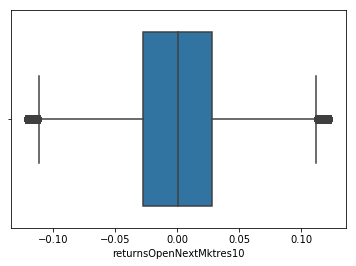

In [26]:
sns.boxplot(x=market_train_df['returnsOpenNextMktres10'])

In [27]:
# take all continuous; maybe remove those returns not Savitzky-Golay-ed, or use it on them too.
X = market_train_df[['volume', 'close', 'open', 'returnsClosePrevRaw1','returnsOpenPrevRaw1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10']]
y = market_train_df['returnsOpenNextMktres10']

Z = market_train_df[['close', 'open', 'volume', 'returnsOpenPrevMktres10']] # for correlation

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Lin Reg

In [29]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)
print('Intercept: %.3f' % slr.intercept_)
print('Beta 1:  %.3f' % slr.coef_[0])
print('Beta 2:  %.3f' % slr.coef_[1])
print('Beta 3:  %.3f' % slr.coef_[2])

y_pred = slr.predict(X_test)
print(y_pred[:5])

Intercept: 0.000
Beta 1:  -0.000
Beta 2:  -0.001
Beta 3:  0.001
[-0.00200549  0.00545931  0.00210071 -0.00193579  0.00273141]


In [30]:
slr.score(X_test, y_test) # R^2

0.006140241800162816

In [31]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_pred))

0.03526378426086331


V priemere je náš model mimo o 6,8 % výnosu.

In [32]:
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f' % (mean_squared_error(y_test, y_pred)))

MSE train: 0.002


# need to remove these outliers, make the returnsOpenNextMktres10 more reliable

trace0 = go.Histogram(
    x=y
)
trace1 = go.Histogram(
    x=y_pred
)
data = [trace0, trace1]
layout = go.Layout(barmode='stack')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='stacked histogram')

# **Decision Tree**

In [33]:
max(y_pred)

0.1355365210199136

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=10,
                               max_depth=7, 
                               random_state=123, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.035201060226746024

trace0 = go.Histogram(
    x=y
)
trace1 = go.Histogram(
    x=y_pred
)
data = [trace0, trace1]
layout = go.Layout(barmode='stack')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='stacked histogram')

# XGBoosted

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
# maybe do GridSearch for optimal parameters
gbm = xgb.XGBRegressor()
reg_cv = GridSearchCV(gbm, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2], 
                            'max_depth': [3,4,6], 
                            'n_estimators': [5, 10,100]})
reg_cv.fit(X_train, y_train)
reg_cv.best_params_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


In [ ]:
gbm = xgb.XGBRegressor(**reg_cv.best_params_)
gbm.fit(X_train,y_train)

In [ ]:
predictions = gbm.predict(X_test)
predictions

In [ ]:
gbm.score(X_test,y_test)

In [ ]:
gbm.score(X_train,y_train)

In [44]:
import xgboost as xgb

#Fitting XGB regressor 
model = xgb.XGBRegressor(n_estimators=10,  
                         max_depth=7, 
                         n_jobs=-1,
                         random_state=123)
model.fit(X_train, y_train)
preds = model.predict(X_test)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [48]:
from sklearn.metrics import explained_variance_score # why
print(explained_variance_score(y_test, preds))

0.007282644915994396


In [46]:
mean_absolute_error(y_test, preds)

0.17414361091175434

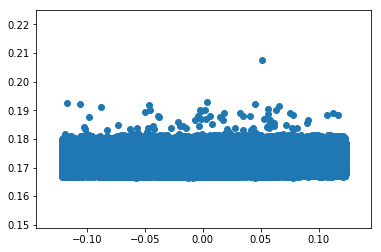

In [47]:
plt.scatter(y_test, preds)
plt.show()